# Investigate Wind Direction

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import math
import numpy as np
import cartopy.crs as ccrs
import geopandas as gpd
import glob
import moviepy.editor as mpy

from palettable.colorbrewer.diverging import RdBu_11

# Load Alpine-3D netCDF file

In [3]:
ds = xr.open_dataset("../output/grids/a3d_grids.nc")

# Plot wind speed and direction from Alpine-3D

In [ ]:
# SNOWPACK topography 
dem = np.flipud(np.loadtxt("../input/surface-grids/dem.asc", skiprows=6))

'''
Calculates U and V components of wind from wind speed and direction. 
Wind direction is the meteorological wind direction (i.e. direction the wind is coming from in degrees)
'''
def calc_U_V(speed, direction):
    U = -speed * np.sin(math.pi / 180 * direction)
    V = -speed * np.cos(math.pi / 180 * direction)
    return U, V

# Get U and V components
U, V = calc_U_V(ds['ws'], ds['dw'])

# Calculate
dswe = ds['swe'] - ds['swe'].isel(time=0)

# Get lat/lon
x_snowpack = ds['easting']
y_snowpack = ds['northing']


# Make movie
# Clear old images, gifs,and movies
!mkdir -p movie_frame
!rm -f movie.gif
!rm -f movie.mp4
!rm -f movie_frame/*

for time_step in range(0, len(ds['time']), 1):
# for time_step in range(0, 2):
    print(time_step)
    plt.clf()
    
    # Plot map of mean wind
    plt.figure(figsize=(30,15))

    # DEM
    contour_levels = np.linspace(dem.min(), dem.max(), 25)
    contour = plt.contour(x_snowpack.values, y_snowpack.values, dem, contour_levels, linestyles='solid', colors='white')
    plt.clabel(contour, fmt = '%.0f', inline = True)

    # Delta SWE
    colormap = RdBu_11.mpl_colormap # works
    plt.pcolor(x_snowpack.values, y_snowpack.values, dswe.isel(time=time_step), \
               cmap = colormap, vmin=-np.abs(dswe).max(), vmax=np.abs(dswe).max())
    plt.colorbar()

    # Wind speed and direction (still need to normalize arrows so that length means the same thing for all time steps)
    spacing = 6
    northing_ind = np.arange(0, len(ds['northing']), spacing)
    easting_ind = np.arange(0, len(ds['easting']), spacing)
    plt.quiver(x_snowpack[easting_ind].values, y_snowpack[northing_ind].values, \
               U.isel(time=time_step)[northing_ind, easting_ind], V.isel(time=time_step)[northing_ind, easting_ind])
    plt.title(ds['time'].isel(time=time_step).values, fontsize=20)
    
    #Save Figure with image number zero padding 
    if time_step < 10:
        plt.savefig("movie_frame/frame_00" + str(time_step) + ".png", dpi=100)
    elif time_step < 100 and time_step > 9:
        plt.savefig("movie_frame/frame_0" + str(time_step) + ".png", dpi=100)
    else:
        plt.savefig("movie_frame/frame_" + str(time_step) + ".png", dpi=100)
    plt.close()
    
# Make a .mp4 movie and gif
file_list = sorted(glob.glob('movie_frame/*.png'))
clip = mpy.ImageSequenceClip(file_list, fps=30)
clip.write_videofile('movie.mp4')
# clip.write_gif(file_name+'.gif')
    

# # Plot map of wind direction
# plt.figure(figsize=(20,10))
# plt.pcolor(x_snowpack.values, y_snowpack.values, ds['dw'].isel(time=time_step), cmap='twilight')
# plt.colorbar()

# # Plot horizontal transect of wind direction
# plt.figure(figsize=(10,5))
# ds['dw'][0,50,:].plot()


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

# Plot a transect of wind speed and topography

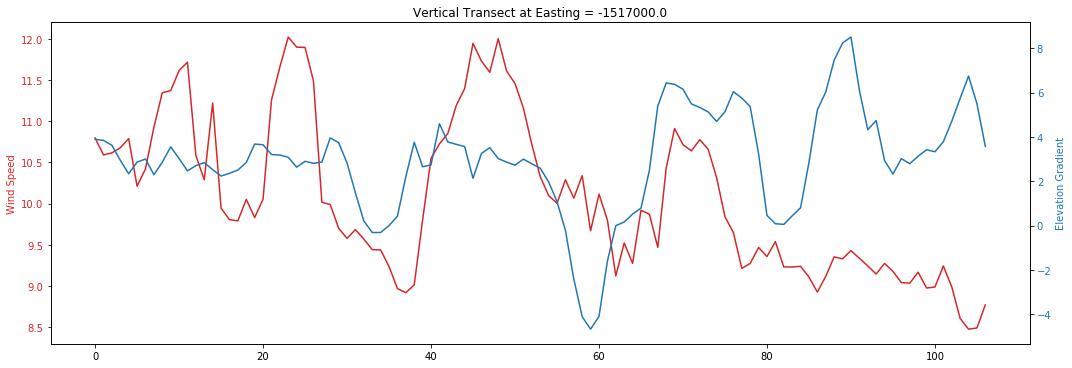

In [4]:
# Calculate transects
ind = 25
ws_transect = ds['ws'].isel(time=0)[:, ind]
# dem_transect = dem[:, ind]
dem_transect = np.flip(np.gradient(dem[:, ind]))

# Plot both transects
fig, ax1 = plt.subplots(figsize=(15,5))

# Wind Speed
color = 'tab:red'
ax1.set_ylabel('Wind Speed', color=color)  
ax1.plot(ws_transect, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx() 

# Elevation
color = 'tab:blue'
ax2.set_ylabel('Elevation Gradient', color=color)  
ax2.plot(dem_transect, color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Settings
fig.tight_layout()  
plt.title("Vertical Transect at Easting = " + str(float(ws_transect['easting'].values)))
plt.show()


# Plot MERRA-2 winds

/projects/erke2265/miniconda/envs/alpine3d/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/projects/erke2265/miniconda/envs/alpine3d/lib/python3.6/site-packages/cartopy/vector_transform.py:140: UserWarning: Some vectors at source domain corners may not have been transformed correctly
  u, v = target_proj.transform_vectors(src_crs, x, y, u, v)


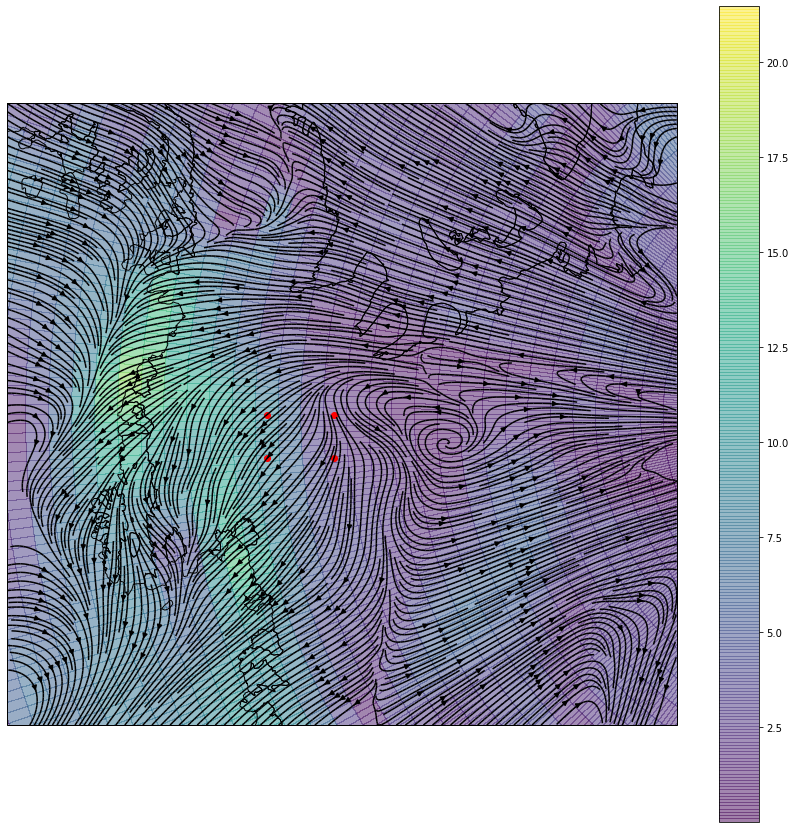

In [5]:
# Define upper left and lower right A3D domain corners in epsg 3031
ncol = 168
nrow = 107
left = -1542000 # done
bottom = -109000 # done
top = bottom + 1000 * (nrow -1)
right = left + 1000 * (ncol -1)

# Look at MERRA-2
M2_U_path = "/scratch/summit/erke2265/MERRA2/U10M_hourly_1980.nc"
M2_V_path = "/scratch/summit/erke2265/MERRA2/V10M_hourly_1980.nc"

# Mean U and V components
M2_U = xr.open_dataset(M2_U_path)
M2_U = M2_U['U10M']
M2_U_mean = M2_U[0,:,:].values
# M2_U_mean = M2_U.mean(dim='time').values

M2_V = xr.open_dataset(M2_V_path)
M2_V = M2_V['V10M']
M2_V_mean = M2_V[0,:,:].values
# M2_V_mean = M2_V.mean(dim='time').values

# Calculate mean wind speed.
ws_mean = np.sqrt( np.power(M2_U_mean,2) + np.power(M2_V_mean,2))

# Load coastlines
df = gpd.read_file("/pl/active/nasa_smb/Data/ADD_Coastline_low_res_polygon.shp")
crs_epsg = ccrs.SouthPolarStereo()
df_epsg = df.to_crs(epsg='3031')

# Generate figure 
fig, axs = plt.subplots(1, 1, subplot_kw={'projection': crs_epsg},
                        figsize=(15, 15))

# Plot coastlines
# axs.set_extent((-180, 180, -90, -60), ccrs.PlateCarree())
axs.set_extent((-110, -70, -85, -70), ccrs.PlateCarree())
axs.add_geometries(df_epsg['geometry'], crs=crs_epsg,
                      facecolor='none', edgecolor='black')

# Plot winds
vector_crs = ccrs.PlateCarree()
space = 1
ws = plt.pcolor(M2_U['lon'].values, M2_U['lat'].values, ws_mean, transform=vector_crs, alpha=0.5)
cbar = plt.colorbar(ws)
streamlines = axs.streamplot(M2_U['lon'].values, M2_U['lat'].values, M2_U_mean, \
            M2_V_mean, color='k', transform=vector_crs, density=5)

# Plot model domain
plt.scatter(left, bottom, c='r', label="A3D Domain")
plt.scatter(left, top, c='r')
plt.scatter(right, bottom, c='r')
plt.scatter(right, top, c='r')
plt.savefig("MERRA-2.pdf", format='pdf', dpi=100)